In [7]:
pip install findspark pandas awswrangler numpy matplotlib seaborn pyspark


[notice] A new release of pip is available: 24.1.2 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import findspark
import pandas as pd
import awswrangler as wr
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import matplotlib.ticker as ticker
import boto3
import statistics

/var/folders/x0/w5vkfm815t50y972318hw4880000gq/T/ipykernel_72134/1860195836.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_result = df.groupby([


Average: 0.1656332134968929
Mode: 0.0
Median: 0.1707604808738668


/var/folders/x0/w5vkfm815t50y972318hw4880000gq/T/ipykernel_72134/1860195836.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_result = df.groupby([


Average: 0.17016923762723546
Mode: 0.0
Median: 0.17711500853195983


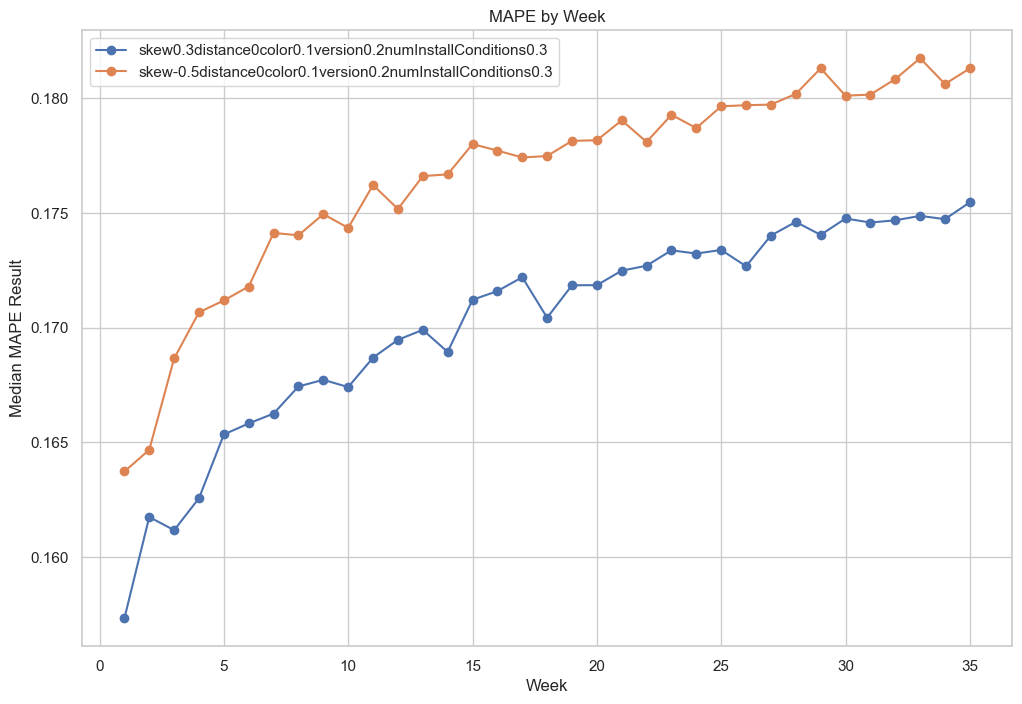

In [9]:
findspark.init()
analysis = [
    "skew0.3distance0color0.1version0.2numInstallConditions0.3",
    "skew-0.5distance0color0.1version0.2numInstallConditions0.3"
]
seaborn.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

for dataset in analysis:
    df = pd.read_parquet(f'../../generate data/5.2/week/{dataset}/')
    df = df[~df["partCodeId"].str.contains("model")]
    df = df[df["week"] > 5]
    df["week"] = df["week"] - 5

    # I want the "deviation to be the maximum between 0 and 1 - (dfquantity - adquantity) / adquantity"
    df["formula_result"] = (df["dfQuantity"] - df["actualQuantity"]).abs() / df["actualQuantity"]
    # Group by the correct columns
    df_result = df.groupby([
        "partCodeId",
        "vehicleModelId",
        "week",
    ]).agg(
        final_result=("formula_result", "mean"),
        number= ("partCodeId", "count"),
    ).reset_index()
    
    df_result = df_result[df_result["number"] > 0 ]

    # df_result.to_parquet("./blah.parquet", index=False)

    # Remove values that are below 0
    df_result = df_result[df_result["final_result"] >= 0]

    # Cap the final_result values at 2
    # df_result["final_result_capped"] = df_result["final_result"].clip(upper=2)

    # Calculate statistics
    average = df_result["final_result"].mean()
    mode = df_result["final_result"].mode()[0]
    median = df_result["final_result"].median()

    print(f"Average: {average}")
    print(f"Mode: {mode}")
    print(f"Median: {median}")

    df_week_median = df_result.groupby("week")["final_result"].quantile(0.5).reset_index()



    # Plot the results
    plt.plot(df_week_median["week"], df_week_median["final_result"], marker='o')
    #add legend with dataset name

plt.title(f"MAPE by Week")
plt.xlabel(f"Week")
plt.ylabel(f"Median MAPE Result")
plt.grid(True)    
plt.legend(analysis)    
plt.show()
